# Design Optimization

This notebook goes over design optimization process by determining important aircraft state and finding optimized dimension around it

From the mission, we know that important aspects of the designed aircraft should be
* Flight Distance D - Covering long range survey
* Altitude Hight H - Optimal resolution for nest detection
* Speed VT - Speed of aircraft to cover area effectively
* TBD


The payload of the mission is a camera. An altitude $H$ and speed $VT$ will be determiend based on optimal hight and frame update rate of the camera. Therefore, sensor payload data must be used to compute optimal flight hight and speed.

Based on mission requirement and FAA regulation, we have constraints set up, as listed below:
* Aircraft Weight $\leq$ 12.5 lbs
* Aircraft Sizing requirements (TBA)

In [ ]:
# Procedure for analysis
# 1. Find H, VT optimal based on sensor spec (GoPro Cameras)
# 2. From H, VT, and Flight Distance input, determine power required & battery amount
# 3. Based on battery amount & power source, estimate aircraft weight from statistical data of UAVs
# 4. From weight, Lift can be determined at steady flight // determine wing characteristic and subsequent drag characteristic
# 5. From wing characteristic, determine optimized aircraft sizing

In [2]:
import casadi as ca
from casadi import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
from casadi.tools.graph import dotgraph
from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())

In [91]:
# 1. Camera Optimization
# Parameter
# Set up dictionary for camera's specification
data = {'Hero5_Black': {'f': {'wide': 14, 'medium': 21, 'narrow': 28},
                        'sensor_size_h': 6.17, 'sensor_size_v': 4.55, 'Weight': 118}
       } # Units: f: mm, sensor size: mm, Weight: g

def sensor_spec(model_name):
    '''
    This function takes name of camera model and output its specficiation
    
    Input: model_name (str)
    Output: specification (dic)
    '''
    specification = data[model_name]
    return specification

def constraint_func(specification, f, u):
    '''
    Take camera spec, extract variables needed, and return constraint vector
    
    Input: specification (dic), f (str), u (vec)
    Output: constraint vector with S, H, VT
    '''
    f = float(specification['f'][f])*1e-3 # Focal Lnegth (m)
    h = float(specification['sensor_size_h'])*1e-3 # Lense Height (m)
    w_camera = float(specification['Weight'])*1e-3 # Camera Weight (kg)
    H = u[0] # Altitude (m)
    VT = u[1] # Velocity (m/s)
    t_exp = 1 # Flight Time (sec)
    
    inside = h/(2*f)
    FOV = 2*H*ca.atan(inside)
    Width = VT*t_exp
    S = 2*H*ca.tan(FOV/2)
    A = S*Width
    #print(S)
    #print(H)
    #print(VT)
    return ca.vertcat(S, H, VT)

def objective_function(constraint):
    '''
    Calculate objective function of the system
    Maximize: Sweep Area S, Altitude H
    Minimize: Velocity VT
    
    Input: constraint (vec)
    Output: trim cost
    '''
    S = constraint[0]
    H = constraint[1]
    VT = constraint[2]
    #print('Scan Area: ', S)
    
    return 10*(1/S)**2 + (1/H)**2 + (1/VT)**2

In [92]:
# Symbolic Variable Setup
H = ca.SX.sym('H')
VT = ca.SX.sym('VT')

u = ca.vertcat(H, VT)

In [93]:
sensor = sensor_spec('Hero5_Black')
f = 'wide'
constraint = constraint_func(sensor, f, u)
opt = objective_function(constraint)

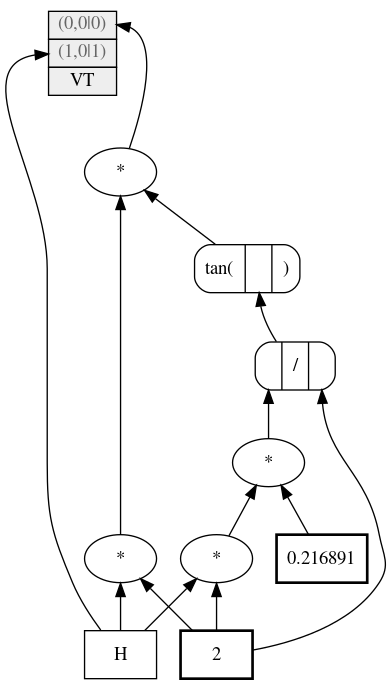

In [94]:
draw_graph(constraint)

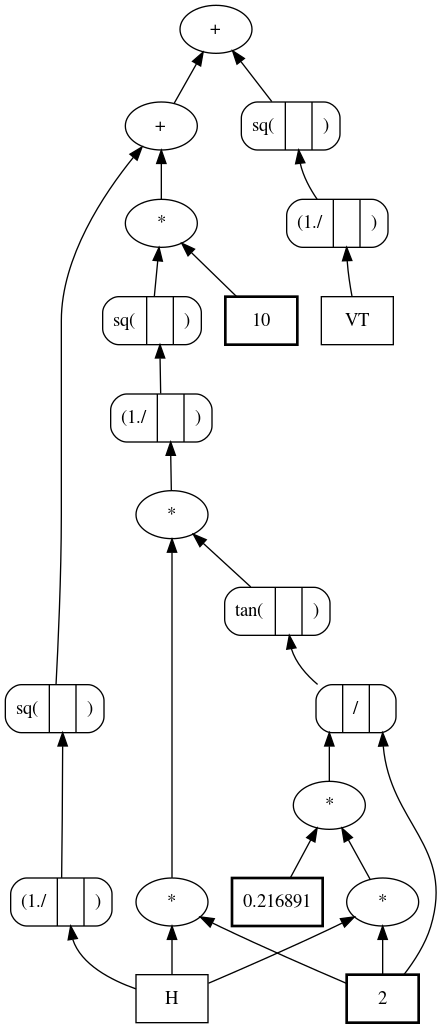

In [95]:
draw_graph(opt)

In [96]:
# Sensor Payload Optimization
def payload_optimization(x0, sensor, f):
    '''
    Setup nlp solver for optimizing Altitude H & Velocity VT
    
    Input: x0 (initial guess, vec), sensor (dic), f (str)
    Output: x_opt (vec)
    '''
    x_design = ca.SX.sym('x_design', 2)
    constraint = constraint_func(sensor, f, x_design)
    trim_cost = objective_function(constraint)
    nlp = {'x': x_design, 'f': trim_cost}
    S = nlpsol('S', 'ipopt', nlp, {'print_time': 0, 'ipopt': {'sb': 'yes','print_level': 0}})
    result = S(x0=x0, lbg=0, ubg=0, lbx = [10, 0], ubx = [120, 10000])
    x_opt = result['x']
    print('Optimized Height: ', x_opt[0], 'm')
    print('Optimized VT: ', x_opt[1], 'm/s')
    print('Calculated Trim Cost: ', result['f'])
    return x_opt

In [97]:
x0 = [60, 150]
x_opt = payload_optimization(x0, sensor, f)

Optimized Height:  65.3113 m
Optimized VT:  2684.74 m/s
Calculated Trim Cost:  0.000235043
